# Feb 25th, 2022 (compare cosine, DMN)

**Motivation**: Compare communities, cosine similarity, DMN mask, render, Dice. <br>

In [6]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [7]:
fig_dir = pjoin(tmp_dir, 'fig_25th')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [8]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [9]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ids

[0, 1, 2, 3, 4]

## $\pi$ compare

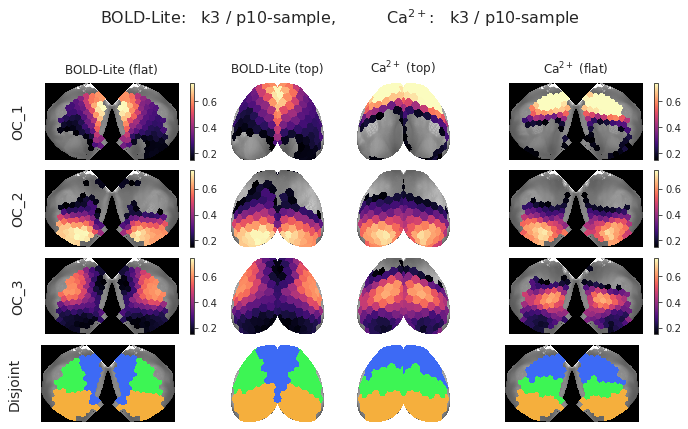

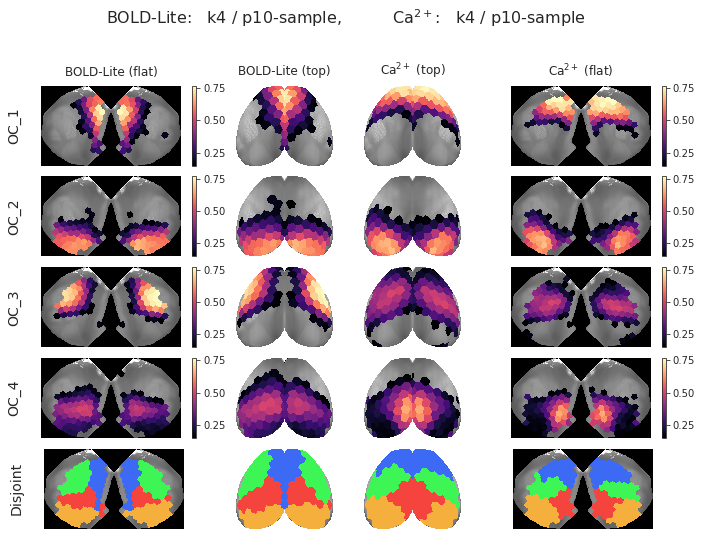

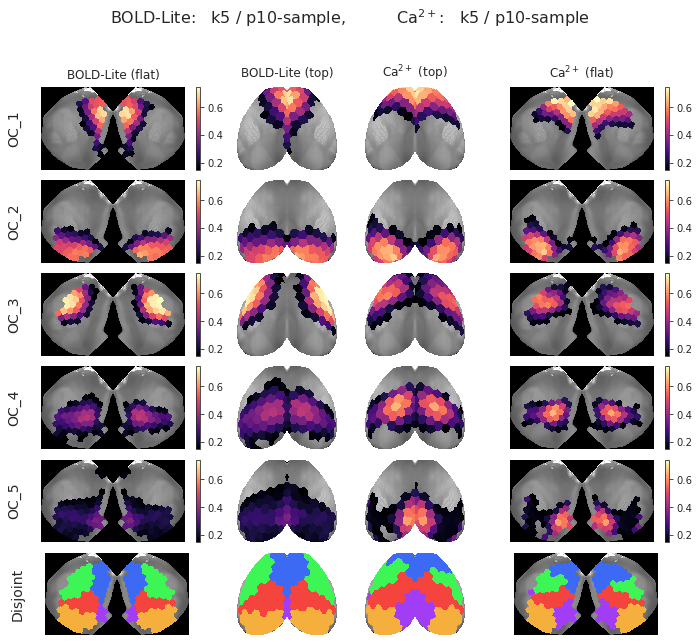

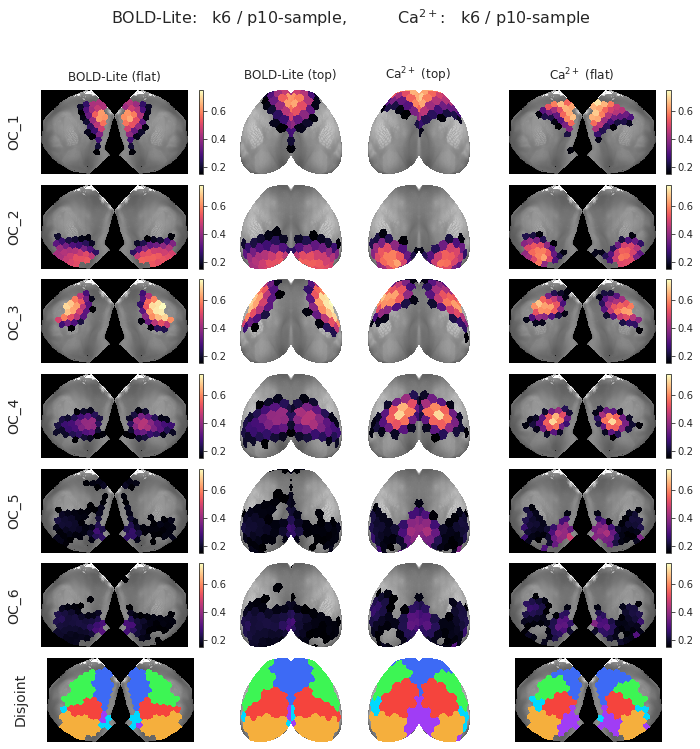

In [10]:
# HIDE CODE


for k in range(3, 7):
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['num_k'] = k
    _props_c['num_k'] = k

    # Group results
    _gr_c = Group(**_props_c).fit_group()
    _gr_b = Group(**_props_b).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.grp_pi,
        XB=_gr_c.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    _gr_b.pi = _gr_b.grp_pi
    _gr_c.pi = _gr_c.grp_pi[ids]

    fig, _ = _gr_c.show(
        _gr_b.project_vec(), _gr_c.project_vec(),
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('magma',) * 2,
        min_thres=0.15,
        display=False,
    )
    sup = f"BOLD-Lite:   k{_props_b.get('num_k')} / {_props_b.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{_props_c.get('num_k')} / {_props_c.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)
    
    name = f'OCs-k={k}'
    figname = f"{name}.pdf"
    fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
    for dpi in [100, 300,]:
        figname = f"{name}_dpi{dpi}.png"
        fig.savefig(
            pjoin(fig_dir, figname),
            dpi=dpi,
            bbox_inches='tight',
            transparent=True,
        )

    display(fig)

### Quantify scores

In [5]:
# HIDE CODE


cos = {}
dlist = []
for k in range(3, 7):
    _props_b = props_bold.copy()
    _props_c = props_ca.copy()
    _props_b['num_k'] = k
    _props_c['num_k'] = k

    # Group results
    _gr_c = Group(**_props_c).fit_group()
    _gr_b = Group(**_props_b).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.grp_pi,
        XB=_gr_c.grp_pi,
        metric='cosine',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    _gr_b.pi = _gr_b.grp_pi
    _gr_c.pi = _gr_c.grp_pi[ids]

    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.pi,
        XB=_gr_c.pi,
        metric='cosine',
    ))
    cos[k] = sim
    
    scores = {
        k + 1: s for k, s in
        enumerate(np.diag(sim))
    }
    scores = {**scores, -1: np.mean(np.diag(sim))}
    dlist.append({
        'k': [k] * len(scores),
        'tag': ['full'] * len(scores),
        'metric': ['cos'] * len(scores),
        'oc_idx': scores.keys(),
        'score': scores.values(),
    })
    
    sim = dist2sim(sp_dist.cdist(
        XA=_gr_b.grp_pi_prune,
        XB=_gr_c.grp_pi_prune[ids],
        metric='cosine',
    ))
    scores = {
        k + 1: s for k, s in
        enumerate(np.diag(sim))
    }
    scores = {**scores, -1: np.mean(np.diag(sim))}
    dlist.append({
        'k': [k] * len(scores),
        'tag': ['prune'] * len(scores),
        'metric': ['cos'] * len(scores),
        'oc_idx': scores.keys(),
        'score': scores.values(),
    })

df = pd.DataFrame(merge_dicts(dlist))

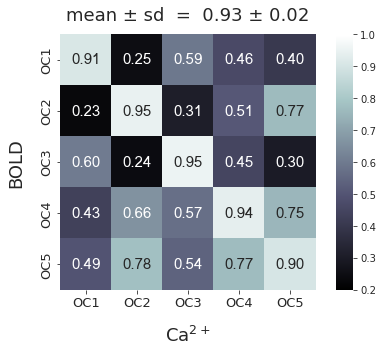

In [78]:
fig, ax = create_figure(figsize=(6, 5))

sns.heatmap(
    cos[5], 
    vmin=0.2,
    vmax=1,
    cmap='bone',
    annot=True,
    square=True,
    fmt='.2f',
    linewidths=0.,
    annot_kws={
        'fontsize': 15,
        'fontname': 'Loma'},
    cbar_kws={
        'aspect': 15,
        'shrink': 1.0},
    ax=ax,
)
ax.set_ylabel('BOLD', fontsize=18,labelpad=15)
ax.set_xlabel(r'Ca$^{2+}$', fontsize=18,  labelpad=15)
ax.set_xticklabels([f"OC{k}" for k in range(1, 6)])
ax.set_yticklabels([f"OC{k}" for k in range(1, 6)])
ax.tick_params(axis='both', labelsize=13)

x = np.diag(cos[5])
msg = f"mean ± sd  =  {x.mean():0.2f} ± {x.std():0.2f}"
ax.set_title(msg, fontsize=18, y=1.03)


name = 'cosine-sim'
# figname = f"{name}.pdf"
# fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(
        pjoin(fig_dir, figname),
        dpi=dpi,
        bbox_inches='tight',
        transparent=True,
    )


plt.show()

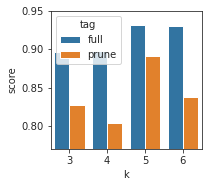

In [80]:
fig, ax = create_figure(figsize=(3, 2.7))
sns.barplot(
    data=df.loc[df['oc_idx'] == -1],
    x='k',
    y='score',
    hue='tag',
    ax=ax,
)
ax.set_ylim(0.77, 0.95)
plt.show()

## Load DMN mask

In [5]:
path = '/home/hadi/Documents/MouseDMN'
file = pjoin(path, 'ica_all_05_icasso_iter_1000_comp_0_mask_z_1_allen_masked_sym_thresh.nii.gz')
img = ants.image_read(file)
img

ANTsImage (RPI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (114, 80, 132)
         Spacing    : (1.0, 1.0, 1.0)
         Origin     : (0.0, 0.0, 0.0)
         Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [6]:
dmn = img.numpy()
dmn = np.transpose(dmn, (2, 1, 0))
dmn = dmn[::-1][:, ::-1, :]
dmn.shape

(132, 80, 114)

In [7]:
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)
regions_depth1 = regions[hcl[:, 2] == 0]

base = Base(mice, mode='ca2', prep_data=False)


len(regions), len(regions_depth1)

(768, 256)

In [8]:
regions_included = [
    int(lbl.split('-')[1])
    for lbl in base.l2n
]
regions_included = [
    mice.parcel.encode(f"1-{c}-0") for
    c in sorted(set(regions_included))
]
regions_included = mice.parcel.complement(regions_included)
len(regions_included)

164

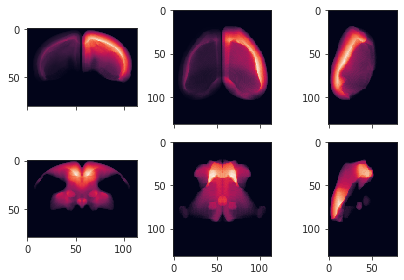

In [9]:
fig, axes = create_figure(2, 3, (6, 4), 'col', 'col')

for i in range(3):
    axes[0, i].imshow(cortex.mean(i))
    axes[1, i].imshow(dmn.mean(i))

In [10]:
mask_optical = np.isin(mice.parcel['cortex'], regions_included)
dmn_masked = dmn * mask_optical

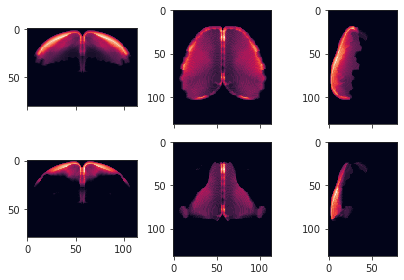

In [12]:
fig, axes = create_figure(2, 3, (6, 4), 'col', 'col')

for i in range(3):
    axes[0, i].imshow(mask_optical.mean(i))
    axes[1, i].imshow((dmn * mask_optical).mean(i))

## Render

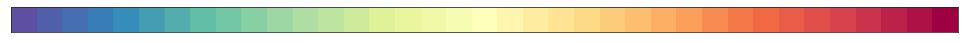

In [13]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('Spectral_r', as_cmap=True)
display_cmap(cmap)

### Full depth-1 ROIs

In [26]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False


scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [27]:
# base_name = 'Isocortex'
# scene.add_brain_region(
#     base_name, alpha=0.2, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

save_name = 'ROIs-depth-1-full'
save_dir = tmp_dir

alpha = 1.0

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions_depth1), total=len(regions_depth1)):
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions_depth1))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/256 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/ROIs-depth-1-full.html

### Full depth-1 ROIs + removed mask

In [30]:
len(regions_depth1), len(regions_included)

(256, 164)

In [36]:
mask_depth1 = np.isin(cortex, regions_depth1)
mask_included = np.isin(cortex, regions_included)
mask_removed = np.logical_and(mask_depth1, ~mask_included)

In [42]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False


scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [43]:
# base_name = 'Isocortex'
# scene.add_brain_region(
#     base_name, alpha=0.2, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

save_name = 'ROIs-depth-1-full_with_removed'
save_dir = tmp_dir

alpha = 1.0

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions_depth1), total=len(regions_depth1)):
    if region_id not in regions_included:
        continue
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions_depth1))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")

x = src_space.map_stack_to(scene.atlas.space, mask_removed)
c = 'k'
colors.append(c)

vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append(f"removed")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/256 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/ROIs-depth-1-full_with_removed.html

## DMN

In [46]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False


scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [47]:
# base_name = 'Isocortex'
# scene.add_brain_region(
# base_name, alpha=0.7, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

alpha = 1.0
    
save_name = 'DMN'
save_dir = tmp_dir

surfaces, names, colors = [], [], []
c = 'r'
colors.append(c)

x = src_space.map_stack_to(scene.atlas.space, dmn)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append(f"DMN")

scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/DMN.html

In [89]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False


scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)


alpha = 1.0
base_name = 'Isocortex'

save_name = 'DMN'
save_dir = tmp_dir

if base_name != 'none':
    scene.add_brain_region(
        base_name, alpha=0.2, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

surfaces, names, colors = [], [], []
c = [i / 255 for i in (95, 77, 178)]
colors.append(c)

x = mask.copy()
x = src_space.map_stack_to(scene.atlas.space, x)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append(f"DMN")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/DMN.html

### DMN cortex

In [240]:
dmn_cortex = dmn * cortex.astype(bool)

In [241]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [242]:
# base_name = 'Isocortex'
# scene.add_brain_region(
# base_name, alpha=0.7, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

alpha = 1.0
    
save_name = 'DMN-ctx'
save_dir = tmp_dir

surfaces, names, colors = [], [], []
c = 'b'
colors.append(c)

x = src_space.map_stack_to(scene.atlas.space, dmn_cortex)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append(save_name)

scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/DMN-ctx.html

### DMN optical subset

In [243]:
dmn_optical = dmn * mask_included.astype(bool)
dmn_complement = np.logical_and(dmn, ~dmn_optical.astype(bool))

In [244]:
alpha_root = 0.2

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = alpha_root
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [245]:
# base_name = 'Isocortex'
# scene.add_brain_region(
# base_name, alpha=0.7, color=rgb2hex([i / 255 for i in mice.al.get(315)['rgb_triplet']]))

alpha = 1.0
    
save_name = 'DMN-optical'
save_dir = tmp_dir

surfaces, names, colors = [], [], []

c = 'b'
colors.append(c)
x = src_space.map_stack_to(scene.atlas.space, dmn_optical)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append('dmn_optical')


c = 'k'
colors.append(c)
x = src_space.map_stack_to(scene.atlas.space, dmn_complement)
vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append('dmn_complement')


scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(save_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/DMN-optical.html

## Dice

In [11]:
dmn_oc_idxs = [0, 3, 4]
gr_ca.pi[dmn_oc_idxs].shape

(3, 174)

<matplotlib.image.AxesImage object at 0x7fc73e543910>

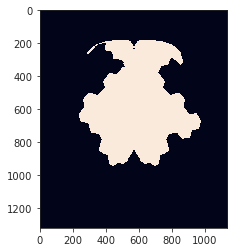

In [12]:
thres = 0.6
x = gr_ca.pi[dmn_oc_idxs].sum(0) > thres
proj = gr_ca.project_vec(x.astype(int), add_disjoint=False)
plt.imshow(proj['top'][0])

In [13]:
scores_dmn = {}
for i in regions_included:
    scores_dmn[i] = overlap_score(cortex == i, dmn.astype(bool))

scores_vec = np.zeros(len(gr_ca.n2l))
for r, sc in scores_dmn.items():
    hh, cc, ll = mice.parcel.decode(r).ravel()
    lbl = f"{hh}-{cc}-{ll}"
    node = gr_ca.l2n[lbl]
    scores_vec[node] = sc

In [14]:
thres_dmn = 0.1
thres_ca = 0.6
thres_bold = 0.6

dmn_oc_idxs = [0, 3, 4]
pi_dmn_ca = gr_ca.pi[dmn_oc_idxs].sum(0)
pi_dmn_bold = gr_bold.pi[dmn_oc_idxs].sum(0)

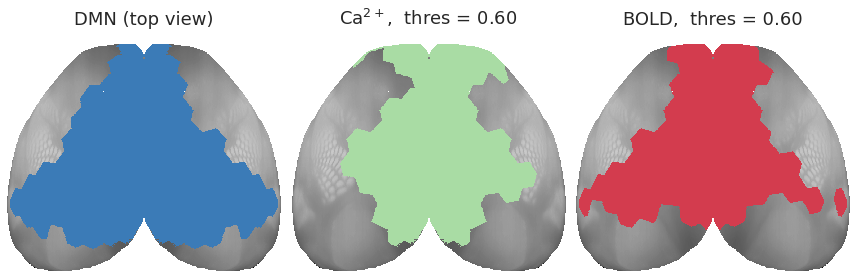

In [16]:
fig, axes = create_figure(1, 3, (12, 4))



proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
for ax in axes.flat:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.92
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_ca] = 0
x2p[x2p > thres_ca] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_bold] = 0
x2p[x2p > thres_bold] = 0.1
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(r'Ca$^{2+}$' + f',  thres = {thres_ca:0.2f}', fontsize=18, y=1.06)
axes[2].set_title(f'BOLD,  thres = {thres_bold:0.2f}', fontsize=18, y=1.06)


remove_ticks(axes)
plt.show()

In [263]:
proj_dmn = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr_dmn = gr_ca.trim2d(proj_dmn)

proj_ca = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr_ca = gr_ca.trim2d(proj_ca)

proj_bold = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr_bold = gr_bold.trim2d(proj_bold)


n = 100
scores_ca = np.zeros((n, n))
scores_bold = np.zeros((n, n))
for i, th_dmn in tqdm(enumerate(np.linspace(0, 1, n)), total=n):
    x_dmn = tr_dmn['proj-top'][0].copy()
    x_dmn[x_dmn <= th_dmn] = 0
    x_dmn[x_dmn > th_dmn] = 1
    for j, th in enumerate(np.linspace(0, 1, n)):
        x_bold = tr_bold['proj-top'][0].copy()
        x_bold[x_bold <= th] = 0
        x_bold[x_bold > th] = 1
        scores_bold[i, j] =dice_score(x_dmn.astype(bool), x_bold.astype(bool))
        
        x_ca = tr_ca['proj-top'][0].copy()
        x_ca[x_ca <= th] = 0
        x_ca[x_ca > th] = 1
        scores_ca[i, j] =dice_score(x_dmn.astype(bool), x_ca.astype(bool))

scores_ca[np.isnan(scores_ca)] = 0
scores_bold[np.isnan(scores_bold)] = 0

  0%|          | 0/100 [00:00<?, ?it/s]

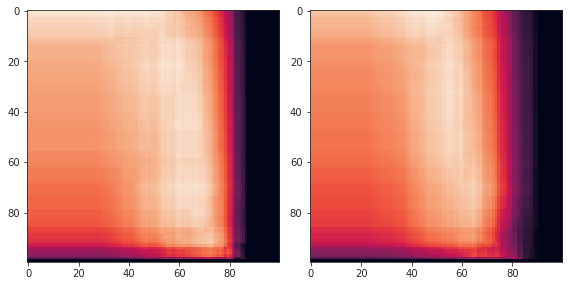

In [264]:
fig, axes = create_figure(1, 2, (8, 4))

axes[0].imshow(scores_ca)
axes[1].imshow(scores_bold)

plt.show()

[<matplotlib.lines.Line2D object at 0x7f3b0566f070>]

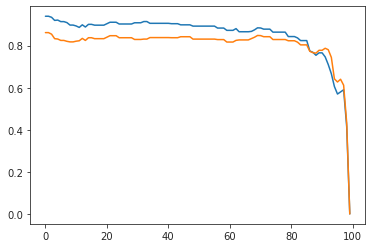

In [285]:
plt.plot(np.max(scores_bold, axis=1))
plt.plot(np.max(scores_ca, axis=1))

In [287]:
a = (np.max(scores_bold, axis=0) + np.max(scores_ca, axis=0)) / 2

[<matplotlib.lines.Line2D object at 0x7f3b05acee20>]

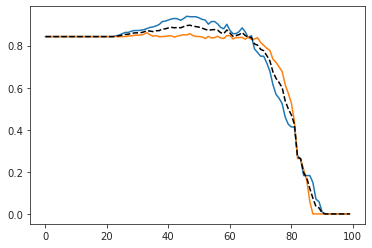

In [288]:
plt.plot(np.max(scores_bold, axis=0))
plt.plot(np.max(scores_ca, axis=0))
plt.plot(a, 'k--')

In [289]:
np.argmax(a)

47

[<matplotlib.lines.Line2D object at 0x7f3b059e8cd0>]

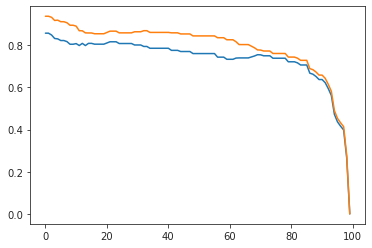

In [291]:
plt.plot(scores_ca[:, 47])
plt.plot(scores_bold[:, 47])

In [307]:
b = (scores_ca[:, 47] + scores_bold[:, 47]) / 2

[<matplotlib.lines.Line2D object at 0x7f3b058c7970>]

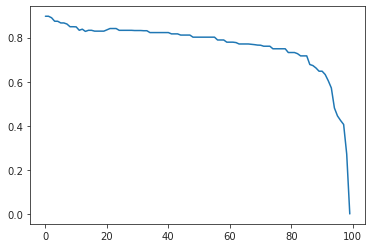

In [308]:
plt.plot(b)

In [310]:
np.argmax(b[15:30])

6

In [311]:
b[21]

0.8412038955091284

In [267]:
np.unravel_index(np.argmax(scores_bold), scores_bold.shape)

(0, 46)

In [278]:
argsorted = np.argsort(scores_ca.flat)[::-1]
[np.unravel_index(i, scores_ca.shape) for i in argsorted[:3]]

[(1, 33), (0, 33), (1, 47)]

In [303]:
thres_dmn = np.linspace(0, 1, n)[0]
thres_ca = np.linspace(0, 1, n)[47]
thres_bold = np.linspace(0, 1, n)[47]

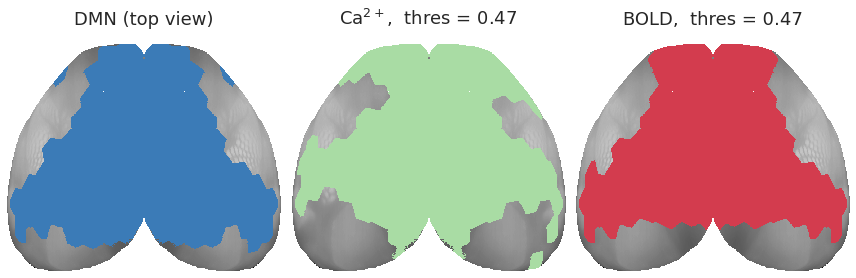

In [304]:
fig, axes = create_figure(1, 3, (12, 4))

for ax in axes.flat:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.92
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_ca] = 0
x2p[x2p > thres_ca] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_bold] = 0
x2p[x2p > thres_bold] = 0.1
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(r'Ca$^{2+}$' + f',  thres = {thres_ca:0.2f}', fontsize=18, y=1.06)
axes[2].set_title(f'BOLD,  thres = {thres_bold:0.2f}', fontsize=18, y=1.06)


remove_ticks(axes)
plt.show()

In [305]:
thres_dmn = np.linspace(0, 1, n)[4]
thres_ca = np.linspace(0, 1, n)[47]
thres_bold = np.linspace(0, 1, n)[47]

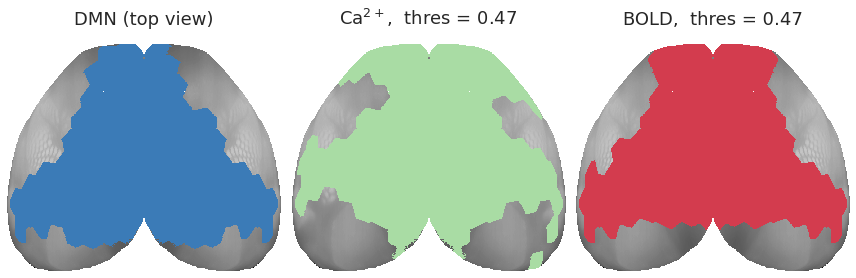

In [306]:
fig, axes = create_figure(1, 3, (12, 4))

for ax in axes.flat:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.92
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_ca] = 0
x2p[x2p > thres_ca] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_bold] = 0
x2p[x2p > thres_bold] = 0.1
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(r'Ca$^{2+}$' + f',  thres = {thres_ca:0.2f}', fontsize=18, y=1.06)
axes[2].set_title(f'BOLD,  thres = {thres_bold:0.2f}', fontsize=18, y=1.06)


remove_ticks(axes)
plt.show()

In [316]:
np.argmax(scores_bold[21]), np.argmax(scores_ca[21])

(54, 59)

In [338]:
thres_dmn = np.linspace(0, 1, n)[21]
thres_ca = np.linspace(0, 1, n)[52]
thres_bold = np.linspace(0, 1, n)[58]

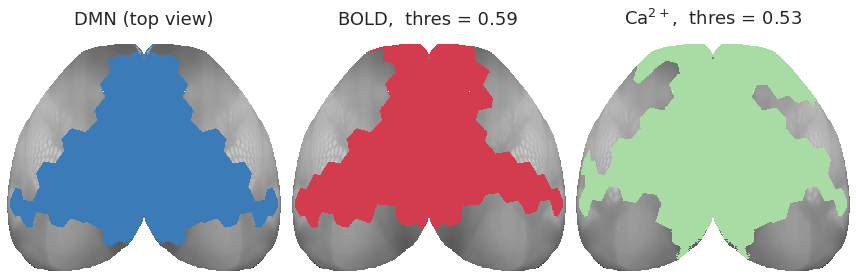

In [339]:
fig, axes = create_figure(1, 3, (12, 4))

for ax in axes.flat:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.92
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_bold] = 0
x2p[x2p > thres_bold] = 0.1
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_ca] = 0
x2p[x2p > thres_ca] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='Spectral', vmin=0, vmax=1.)

axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(f'BOLD,  thres = {thres_bold:0.2f}', fontsize=18, y=1.06)
axes[2].set_title(r'Ca$^{2+}$' + f',  thres = {thres_ca:0.2f}', fontsize=18, y=1.06)


remove_ticks(axes)

name = f'DMN-compare'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()

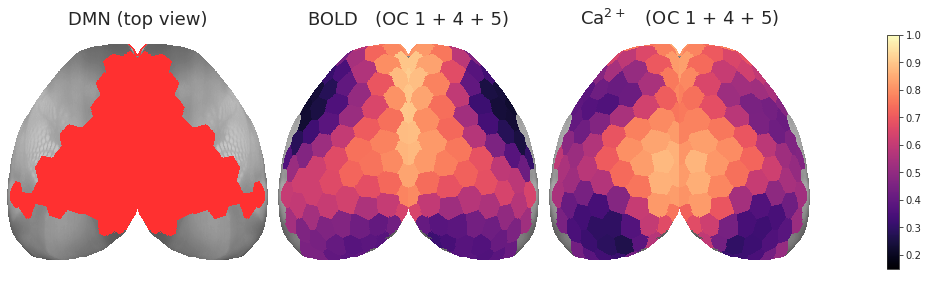

In [42]:
fig, axes = create_figure(1, 4, (13, 4), width_ratios=[1] * 3 + [0.3])

for ax in axes.flat[:3]:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='seismic', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='magma', vmin=0.15, vmax=1.0)#, cmap='Spectral', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p = np.ma.masked_where(x2p == 0, x2p)
im = axes[2].imshow(x2p, cmap='magma', vmin=0.15, vmax=1.0)
plt.colorbar(im, ax=axes[3])

axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(f'BOLD   (OC 1 + 4 + 5)', fontsize=18, y=1.06)
axes[2].set_title(r'Ca$^{2+}$' + '   (OC 1 + 4 + 5)', fontsize=18, y=1.06)

remove_ticks(axes)

name = f'DMN-compare-memship'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()

In [43]:
n = 100

In [44]:
thres_dmn = np.linspace(0, 1, n)[21]
thres_ca = np.linspace(0, 1, n)[52]
thres_bold = np.linspace(0, 1, n)[58]

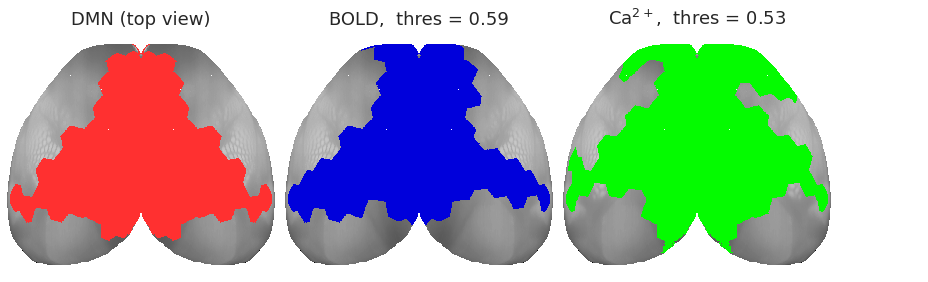

In [47]:
fig, axes = create_figure(1, 4, (13, 4), width_ratios=[1] * 3 + [0.3])

for ax in axes.flat[:3]:
    x2p = np.ma.masked_where(tr['top'] == 0, tr['top'])
    ax.imshow(x2p, cmap='Greys_r')

proj = gr_ca.project_vec(scores_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_dmn] = 0
x2p[x2p > thres_dmn] = 0.7
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[0].imshow(x2p, cmap='seismic', vmin=0, vmax=1.)


proj = gr_bold.project_vec(pi_dmn_bold, add_disjoint=False)
tr = gr_bold.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_bold] = 0
x2p[x2p > thres_bold] = 0.20
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[1].imshow(x2p, cmap='seismic', vmin=0, vmax=1.)


proj = gr_ca.project_vec(pi_dmn_ca, add_disjoint=False)
tr = gr_ca.trim2d(proj)
x2p = tr['proj-top'][0]
x2p[x2p <= thres_ca] = 0
x2p[x2p > thres_ca] = 0.99
x2p = np.ma.masked_where(x2p == 0, x2p)
axes[2].imshow(x2p, cmap='brg', vmin=0, vmax=1.)

axes[0].set_title('DMN (top view)', fontsize=18, y=1.06)
axes[1].set_title(f'BOLD,  thres = {thres_bold:0.2f}', fontsize=18, y=1.06)
axes[2].set_title(r'Ca$^{2+}$' + f',  thres = {thres_ca:0.2f}', fontsize=18, y=1.06)


remove_ticks(axes)

name = f'DMN-compare'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight')

plt.show()